In [165]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import heapq
import time
import tracemalloc
import pandas as pd

In [166]:
generated_data = None #global variable

def generate_data(n, d):
    global generated_data
    generated_data = np.random.rand(n, d) * 10

    if d == 2:
        plt.figure(figsize=(6, 6))
        plt.scatter(generated_data[:, 0], generated_data[:, 1])
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.title("Random 2D Dataset")
        plt.show()
    else:
        print(f"Generated dataset with shape: {generated_data.shape}")

In [167]:
class KDTreeNode:
    def __init__(self, point,axis, left=None, right=None):
        self.point = point
        self.axis=axis
        self.left = left
        self.right = right

class KDTree:
    def __init__(self, data):
      if len(data) >0:
        self.root = self._build_tree(data)
      else:
        self.root = None

    def _build_tree(self, data, depth=0):
        if len(data) == 0:
            return None
        k = data.shape[1]
        axis = depth % k
        sorted_data = data[data[:, axis].argsort()]
        median_idx = len(sorted_data) // 2
        return KDTreeNode(
            point=sorted_data[median_idx],
            axis=axis,
            left=self._build_tree(sorted_data[:median_idx], depth + 1),
            right=self._build_tree(sorted_data[median_idx + 1:], depth + 1)
        )

    def _distance(self, point1, point2):
        return np.linalg.norm(point1 - point2)

    def _k_closest_points(self, target, k, node, depth=0, heap=None):
        if node is None:
            return

        dist = self._distance(target, node.point)
        if len(heap) < k:
            heapq.heappush(heap, (-dist, node.point))
        elif dist < -heap[0][0]:
            heapq.heappushpop(heap, (-dist, node.point))

        axis = depth % len(target)
        if target[axis] < node.point[axis]:
            next_branch, opposite_branch = node.left, node.right
        else:
            next_branch, opposite_branch = node.right, node.left

        self._k_closest_points(target, k, next_branch, depth + 1, heap)

        if len(heap) < k or abs(target[axis] - node.point[axis]) < -heap[0][0]:
            self._k_closest_points(target, k, opposite_branch, depth + 1, heap)

    def k_nearest_neighbors(self, target, k=5):
        if self.root is None:
            raise ValueError("KD-Tree is empty. Cannot find nearest neighbors.")

        heap = []
        self._k_closest_points(target, k, self.root, 0, heap)
        return [point for _, point in sorted(heap, reverse=True)]

In [168]:
def plot_kd_tree(node, bounds, depth=0):
    if node is None:
        return

    axis = node.axis
    split_value = node.point[axis]
    x_bounds, y_bounds = bounds

    if axis == 0:
        plt.plot([split_value, split_value], y_bounds, color="black", linestyle="--")
        left_bounds = [[x_bounds[0], split_value], y_bounds]
        right_bounds = [[split_value, x_bounds[1]], y_bounds]
    elif axis == 1:
        plt.plot(x_bounds, [split_value, split_value], color="black", linestyle="--")
        left_bounds = [x_bounds, [y_bounds[0], split_value]]
        right_bounds = [x_bounds, [split_value, y_bounds[1]]]

    plot_kd_tree(node.left, left_bounds, depth + 1)
    plot_kd_tree(node.right, right_bounds, depth + 1)


In [169]:
class LSH:
    def __init__(self, num_hash_functions, num_hyperplanes, num_dimensions):
        self.num_hash_functions = num_hash_functions
        self.num_hyperplanes = num_hyperplanes
        self.num_dimensions = num_dimensions
        self.hyperplanes = [self._generate_hyperplanes() for _ in range(num_hash_functions)]
        self.buckets = defaultdict(list)

    def _generate_hyperplanes(self):
        return np.random.randn(self.num_hyperplanes, self.num_dimensions)

    def _hash_point(self, point, hyperplanes):
        return ''.join(['1' if np.dot(point, plane) >= 0 else '0' for plane in hyperplanes])

    def fit(self, data):
        self.data = data  # To store data in the model
        for idx, point in enumerate(data):
            for i, hyperplanes in enumerate(self.hyperplanes):
                hash_value = self._hash_point(point, hyperplanes)
                self.buckets[(i, hash_value)].append(idx)

    def query(self, point, num_candidates):
        candidate_set = set()

        # Collect candidates from the same hash bucket
        for i, hyperplanes in enumerate(self.hyperplanes):
            hash_value = self._hash_point(point, hyperplanes)
            candidate_set.update(self.buckets.get((i, hash_value), []))

        distances = []
        for idx in candidate_set:
            distance = np.linalg.norm(point - self.data[idx])
            distances.append((idx, distance))

        distances.sort(key=lambda x: x[1])


        nearest_indices = [idx for idx, dist in distances[:num_candidates]]

        nearest_indices = [idx for idx in nearest_indices if not np.array_equal(self.data[idx], point)]

        return nearest_indices  # Return the indices of the closest candidates excluding the query point


In [170]:
def plot_lsh_hyperplane(data, query_point, hyperplanes, neighbor_indices, k):
    for plane_set in hyperplanes:
        for plane in plane_set:
            x_vals = np.linspace(0, 10, 100)
            y_vals = -(plane[0] / plane[1]) * x_vals if plane[1] != 0 else np.zeros_like(x_vals)
            plt.plot(x_vals, y_vals, linestyle = '--', color="green", alpha=0.3, label="Hyperplane" if plane is plane_set[0] else None)

    x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
    y_min, y_max = np.min(data[:, 1]), np.max(data[:, 1])
    padding = 1
    plt.xlim(x_min - padding, x_max + padding)
    plt.ylim(0,10)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"{k-1} Nearest Neighbors and Hyperplanes for Query Point")
    plt.legend()
    plt.show()

In [171]:
class NaiveKNN:
    def __init__(self, k):
        self.k = k

    def fit(self, data):
        self.data = data

    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2)

    def k_nearest_neighbors(self, query_point,k):
        distances = [self.euclidean_distance(query_point, data_point) for data_point in self.data]
        nearest_indices = np.argsort(distances)[:self.k]
        nearest_indices = [idx for idx in nearest_indices if not np.array_equal(self.data[idx], query_point)]
        return nearest_indices


In [172]:
lsh_model = None
kd_tree=None
naive_knn=None

def fit_models(n, d):
    global lsh_model,kd_tree,naive_knn,generated_data
    if generated_data is not None:
        lsh_model = LSH(num_hash_functions=5, num_hyperplanes=10, num_dimensions=d)
        lsh_model.fit(generated_data)
        kd_tree=KDTree(generated_data)
        naive_knn=NaiveKNN(k=6)
        naive_knn.fit(generated_data)
        print("LSH and KD-Tree models fitted on the generated dataset.")

In [173]:
n_values = [100, 500, 1000, 5000]
d_values = [2, 5, 10, 20]
k = 5
query_point = np.random.rand(max(d_values))
results = []


def benchmark_model(model_name, model_class, data, query_point):
    # Measuring training time and memory usage
    start_time = time.time()
    tracemalloc.start()
    model = model_class()
    if model_name == "LSH":  # LSH needs extra initialization parameters
        model = model_class(num_hash_functions=5, num_hyperplanes=10, num_dimensions=data.shape[1])
    model.fit(data)
    train_time = time.time() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Measuring query time
    start_time = time.time()
    neighbors = model.query(query_point, num_candidates=k)
    query_time = time.time() - start_time

    return train_time, query_time, peak_memory / (1024 ** 2)  # Memory in MB

class LSHWrapper:
    def __init__(self, num_hash_functions=5, num_hyperplanes=10, num_dimensions=2):
        self.lsh = LSH(num_hash_functions, num_hyperplanes, num_dimensions)

    def fit(self, data):
        self.lsh.fit(data)

    def query(self, point, num_candidates=k+1):
        return self.lsh.query(point, num_candidates)

class KDTWrapper:
    def __init__(self):
        self.tree = None

    def fit(self, data):
        self.tree=KDTree(data)

    def query(self, point, num_candidates=k+1):
        return self.tree.k_nearest_neighbors(point, num_candidates)

class NaiveKNNWrapper:
    def __init__(self):
        self.knn = None

    def fit(self, data):
        self.knn = NaiveKNN(k=k+1)
        self.knn.fit(data)

    def query(self, point, num_candidates=k+1):
        return self.knn.k_nearest_neighbors(point,k=num_candidates)

for n in n_values:
    for d in d_values:
        data = np.random.rand(n, d)
        query = query_point[:d]

        for model_name, model_class in [("LSH", LSHWrapper), ("KD-Tree", KDTWrapper), ("Naive k-NN", NaiveKNNWrapper)]:
            train_time, query_time, memory = benchmark_model(model_name, model_class, data, query)
            results.append({"Model": model_name, "n": n, "d": d,
                            "Train Time (s)": train_time, "Query Time (s)": query_time, "Memory (MB)": memory})


results_df = pd.DataFrame(results)
results_df.sort_values(by=["Model", "n", "d"], inplace=True)
results_df.reset_index(drop=True, inplace=True)


from IPython.display import display
display(results_df)


,Model,n,d,Train Time (s),Query Time (s),Memory (MB)
0,KD-Tree,100,2,0.002234,0.000210,0.054756
1,KD-Tree,100,5,0.001954,0.000584,0.061012
2,KD-Tree,100,10,0.001973,0.000661,0.081100
3,KD-Tree,100,20,0.001989,0.000677,0.125481
4,KD-Tree,500,2,0.009483,0.000323,0.248302
5,KD-Tree,500,5,0.012929,0.002152,0.339058
6,KD-Tree,500,10,0.009301,0.003067,0.491333
7,KD-Tree,500,20,0.011896,0.002983,0.798039
8,KD-Tree,1000,2,0.018871,0.000272,0.511333
9,KD-Tree,1000,5,0.018597,0.000978,0.725117


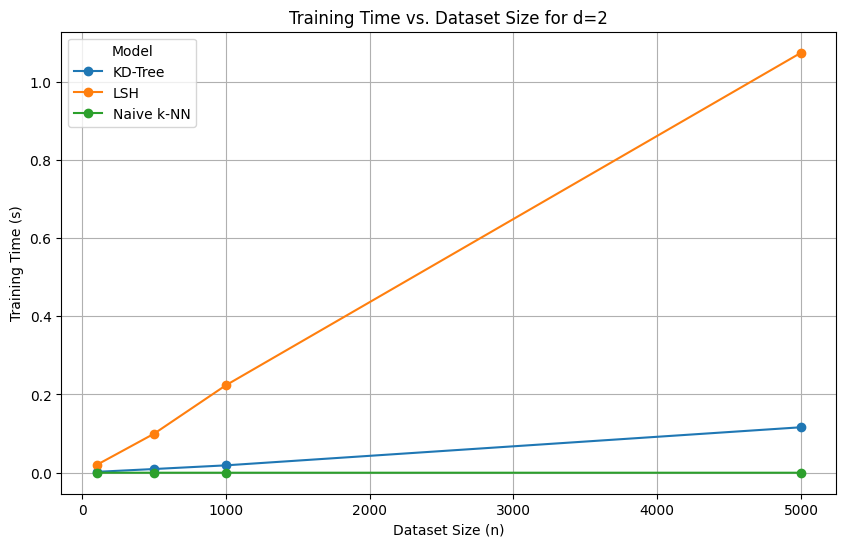

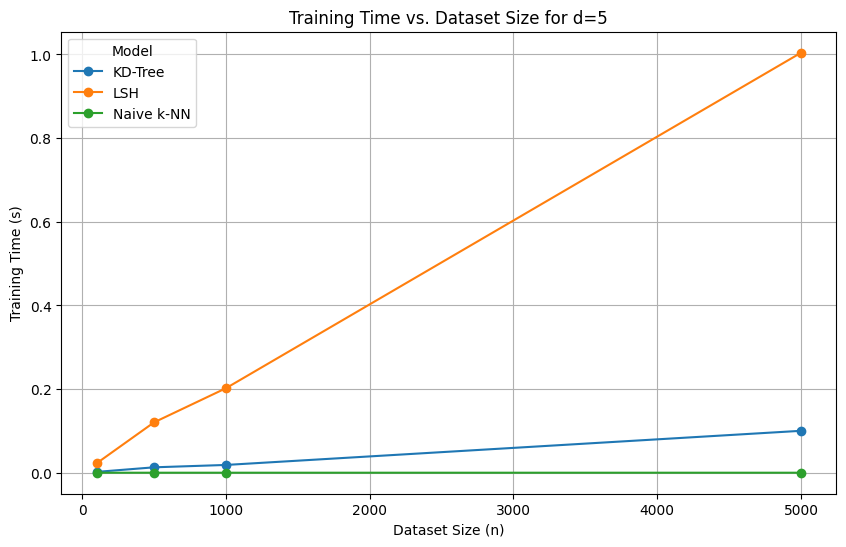

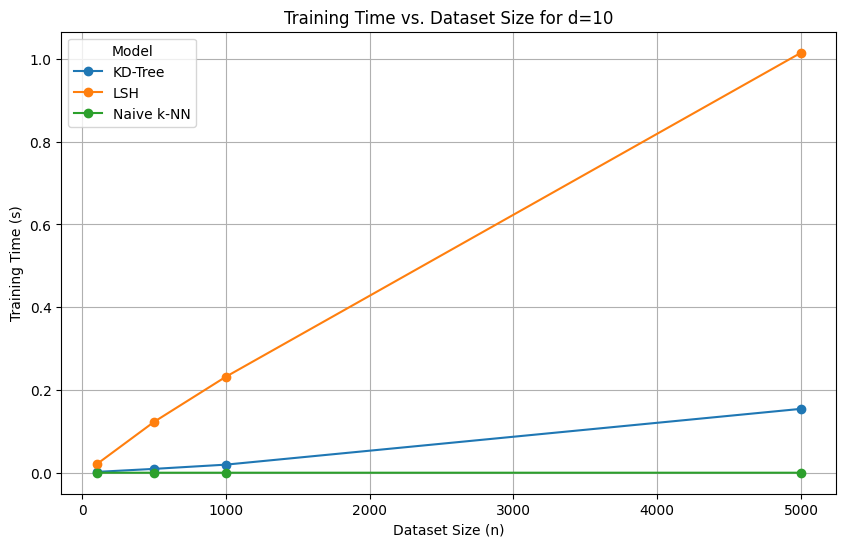

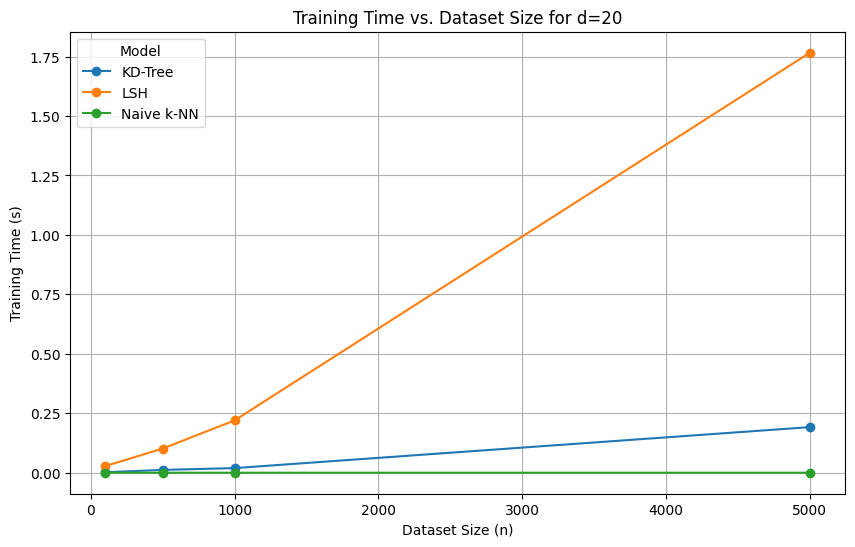

In [174]:
import matplotlib.pyplot as plt

for d_value in d_values:
    filtered_data = results_df[results_df['d'] == d_value]
    train_data = filtered_data.pivot_table(index="n", columns="Model", values="Train Time (s)")

    train_data.plot(kind="line", marker="o", figsize=(10, 6))
    plt.title(f"Training Time vs. Dataset Size for d={d_value}")
    plt.xlabel("Dataset Size (n)")
    plt.ylabel("Training Time (s)")
    plt.legend(title="Model")
    plt.grid()
    plt.show()



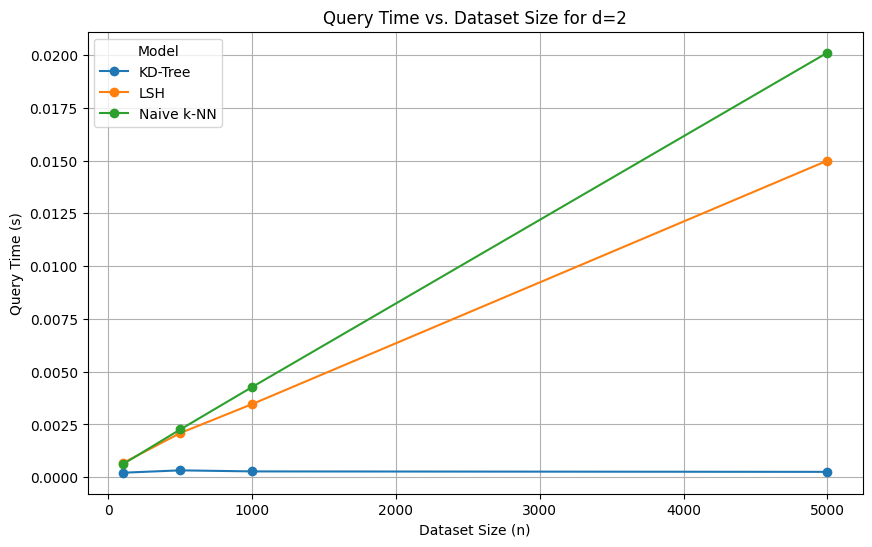

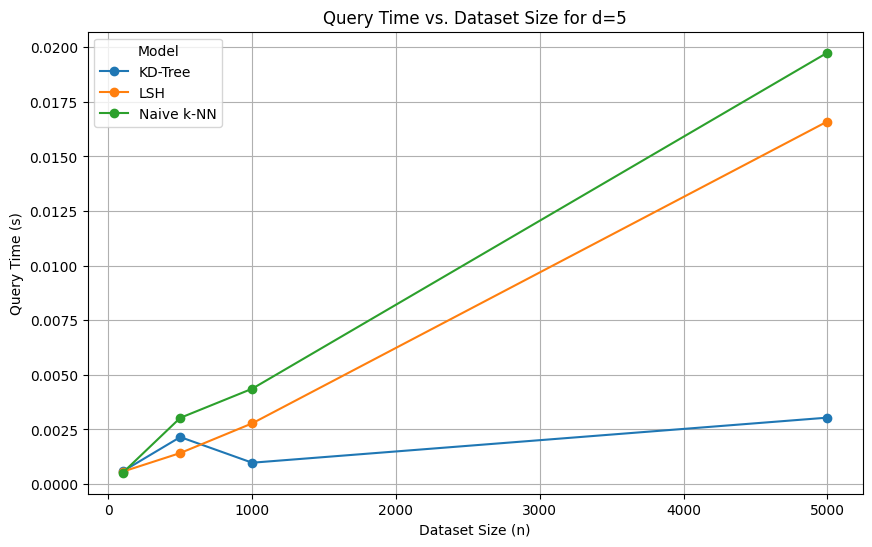

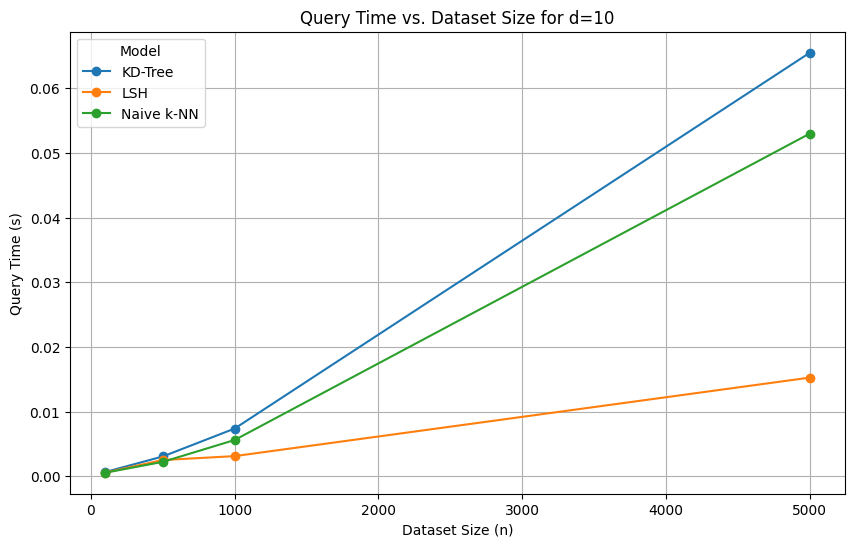

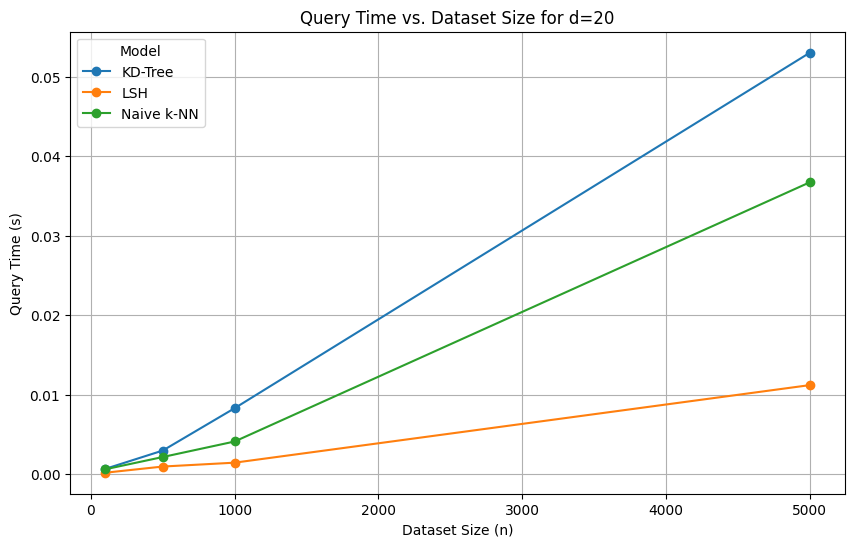

In [175]:
for d_value in d_values:
    filtered_data = results_df[results_df['d'] == d_value]

    query_data = filtered_data.pivot_table(index="n", columns="Model", values="Query Time (s)")

    query_data.plot(kind="line", marker="o", figsize=(10, 6))
    plt.title(f"Query Time vs. Dataset Size for d={d_value}")
    plt.xlabel("Dataset Size (n)")
    plt.ylabel("Query Time (s)")
    plt.legend(title="Model")
    plt.grid()
    plt.show()



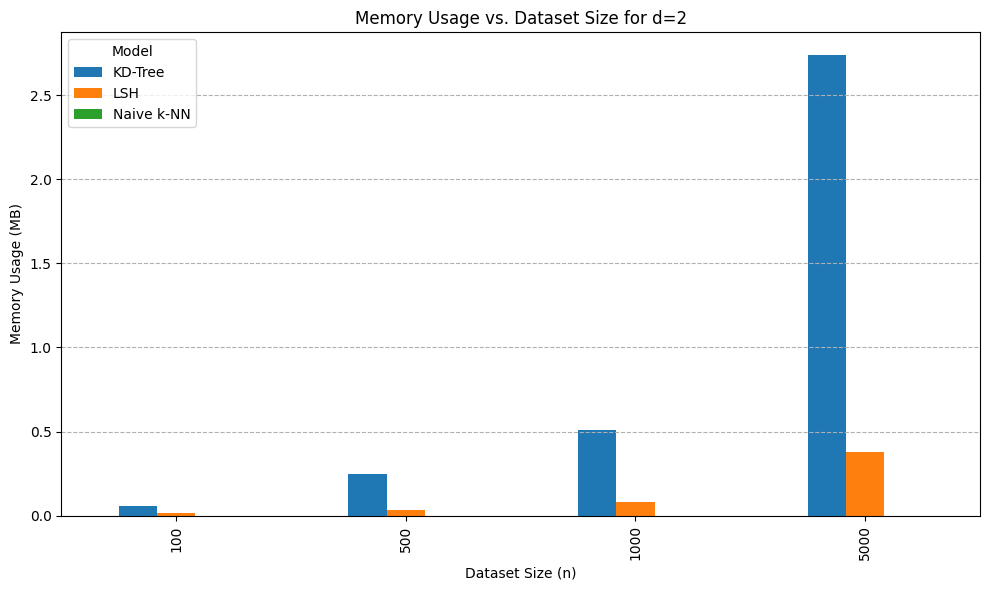

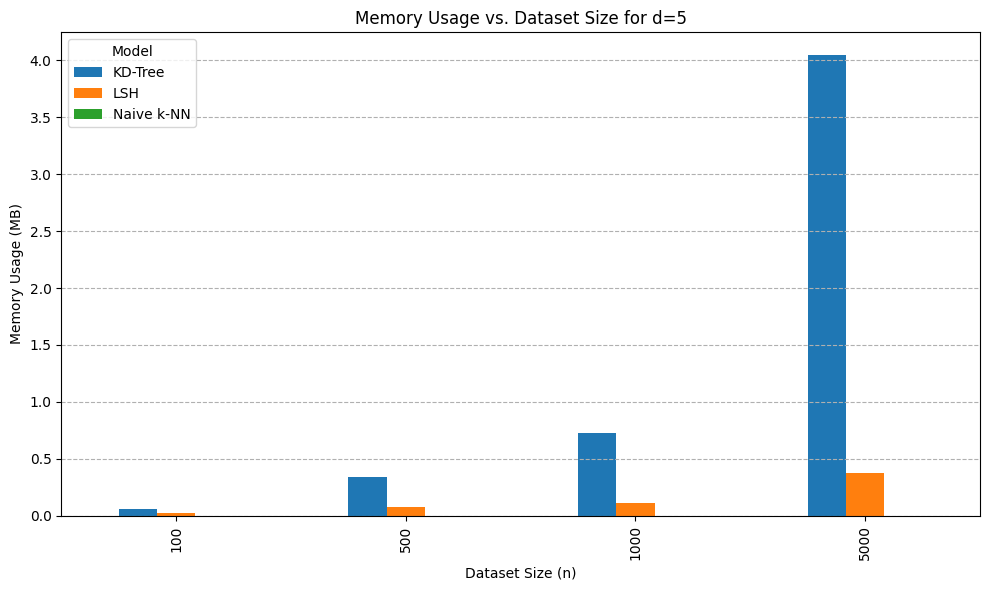

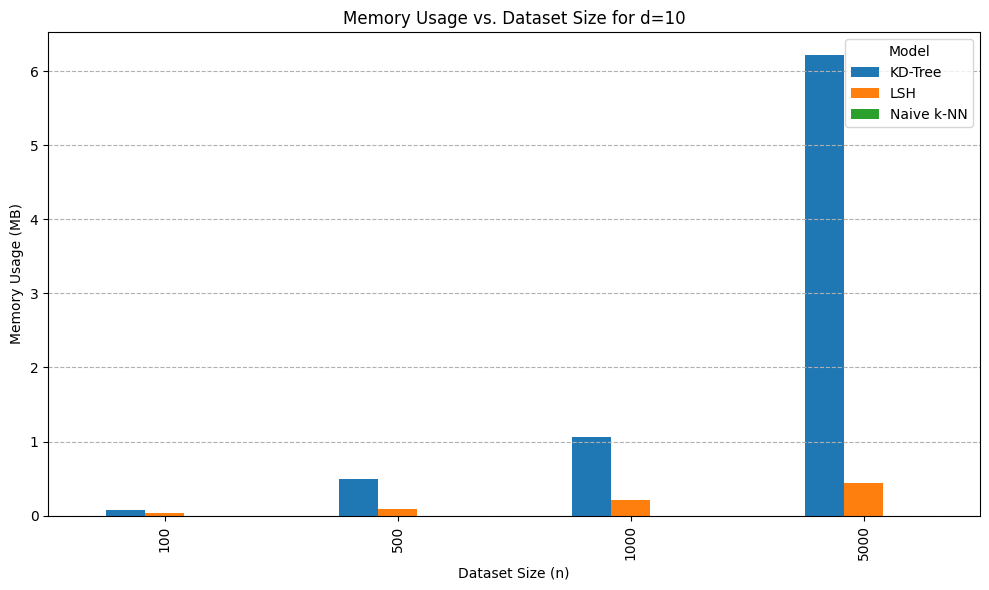

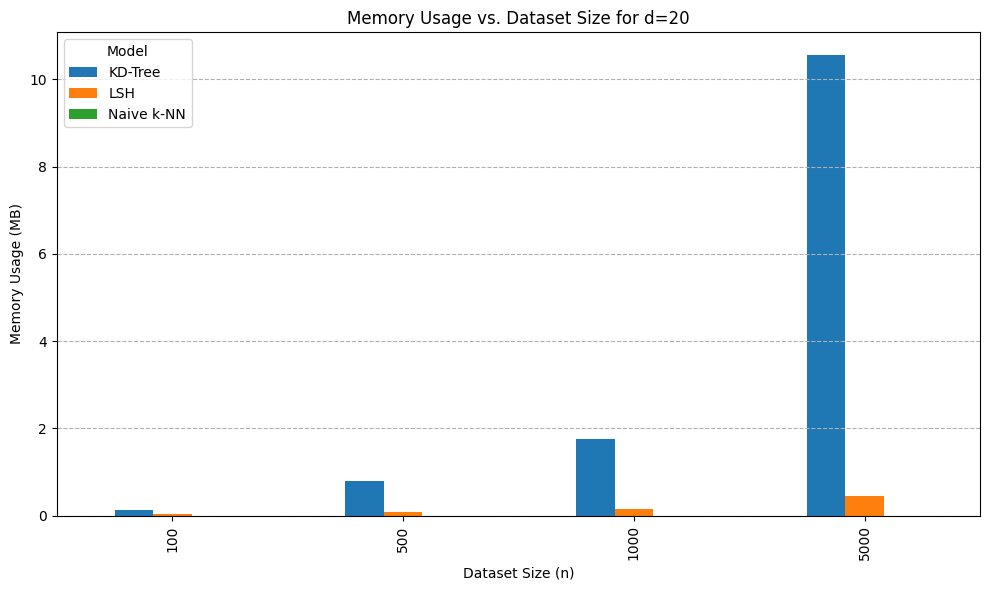

In [176]:
for d_value in d_values:
    filtered_data = results_df[results_df['d'] == d_value]
    memory_data = filtered_data.pivot_table(index="n", columns="Model", values="Memory (MB)")
    memory_data.plot(kind="bar", figsize=(10, 6))
    plt.title(f"Memory Usage vs. Dataset Size for d={d_value}")
    plt.xlabel("Dataset Size (n)")
    plt.ylabel("Memory Usage (MB)")
    plt.legend(title="Model")
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()



In [177]:
def compare_neighbors(query_idx, k, exact_neighbors, approx_neighbors):
    exact_set = set(exact_neighbors)
    approx_set = set(approx_neighbors)

    # Neighbors found by both methods
    common_neighbors = exact_set & approx_set
    missed_neighbors = exact_set - approx_set
    return common_neighbors, missed_neighbors

In [178]:
def query_visualize(index, model_type, k=5 + 1):
    query_point = generated_data[index]

    if generated_data.shape[1] != 2:
        print("For d != 2, displaying the details of the nearest neighbors.")

        if model_type == "KD-Tree":
            if kd_tree is None:
                print("Error: KD-Tree model is not initialized.")
                return

            nearest_neighbors = kd_tree.k_nearest_neighbors(query_point, k=k)
            neighbor_indices = []
            distances = []

            for neighbor in nearest_neighbors:
                if not np.array_equal(neighbor, query_point):  # Exclude query point
                    idx = np.where((generated_data == neighbor).all(axis=1))[0]
                    if idx.size > 0:
                        neighbor_indices.append(idx[0])
                        distances.append(np.linalg.norm(neighbor - query_point))

            print(f"Query Point Index: {index}")
            print("Neighbor Indices and Distances:")
            for i, (idx, dist) in enumerate(zip(neighbor_indices, distances)):
                print(f"Neighbor {i + 1}: Index = {idx}, Distance = {dist}")

        elif model_type == "LSH":
            if lsh_model is None:
                print("Error: LSH model is not initialized.")
                return

            neighbor_indices = lsh_model.query(query_point, k)
            neighbor_indices = [idx for idx in neighbor_indices if not np.array_equal(generated_data[idx], query_point)]

            print(f"Query Point Index: {index}")
            print("Neighbor Indices:")
            for i, idx in enumerate(neighbor_indices):
                print(f"Neighbor {i + 1}: Index = {idx}")

        elif model_type == "Naive k-NN":
            if naive_knn is None:
                print("Error: Naive k-NN model is not initialized.")
                return

            neighbor_indices = naive_knn.k_nearest_neighbors(query_point, k)
            print(f"Query Point Index: {index}")
            print("Neighbor Indices:")
            for i, idx in enumerate(neighbor_indices):
                print(f"Neighbor {i + 1}: Index = {idx}")
    else:
        exact_model = NaiveKNNWrapper()
        exact_model.fit(generated_data)
        exact_neighbors = exact_model.query(query_point, k)

        if model_type == "KD-Tree":
            if kd_tree is None:
                print("Error: KD-Tree model is not initialized.")
                return

            nearest_neighbors = kd_tree.k_nearest_neighbors(query_point, k=k)
            neighbor_indices = [
                idx for neighbor in nearest_neighbors
                if not np.array_equal(neighbor, query_point)
                for idx in np.where((generated_data == neighbor).all(axis=1))[0]
            ]

        elif model_type == "LSH":
          if lsh_model is None:
            print("Error: LSH model is not initialized.")
            return

          neighbor_indices = lsh_model.query(query_point,k + 1)
          neighbor_indices = [idx for idx in neighbor_indices if idx != index]  # Exclude query point

        elif model_type == "Naive k-NN":
            if naive_knn is None:
                print("Error: Naive k-NN model is not initialized.")
                return

            neighbor_indices = naive_knn.k_nearest_neighbors(query_point, k)

        common, missed = compare_neighbors(index, k, exact_neighbors, neighbor_indices)

        plt.figure(figsize=(6, 6))
        plt.scatter(generated_data[:, 0], generated_data[:, 1], color="gray", label="Data Points")
        plt.scatter(query_point[0], query_point[1], color="red", s=100, label="Query Point", edgecolor="black")
        for idx in exact_neighbors:
            plt.scatter(generated_data[idx][0], generated_data[idx][1], color="green", label="Exact Neighbor" if idx == exact_neighbors[0] else "")
        for idx in missed:
            plt.scatter(generated_data[idx][0], generated_data[idx][1], color="black", label="Missed Neighbor" if idx == list(missed)[0] else "")

        if model_type == "KD-Tree":
            plot_kd_tree(kd_tree.root, bounds=[[0, 10], [0, 10]])  # Assuming data range is 0-10

        if model_type=="LSH":
          plot_lsh_hyperplane(generated_data,query_point,lsh_model.hyperplanes,neighbor_indices,k)
        else:
          plt.xlabel("Dimension 1")
          plt.ylabel("Dimension 2")
          plt.title(f"{k - 1} Nearest Neighbors (Model: {model_type}) for Point {index}")
          plt.legend()
          plt.grid()
          plt.show()


In [179]:
def update_query_index_slider(*args):
    query_index_slider.max = n_slider.value - 1
    query_index_slider.value = min(query_index_slider.value, query_index_slider.max)

n_slider = widgets.IntSlider(value=100, min=10, max=1000, step=100, description="n (samples)")
d_slider = widgets.IntSlider(value=2, min=2, max=10, step=1, description="d (dimensions)")
query_index_slider = widgets.IntSlider(value=0, min=0, max=n_slider.value-1, step=1, description="Query Index")
model_type_dropdown = widgets.Dropdown(options=["LSH", "KD-Tree","Naive k-NN"], description="Model Type")
n_slider.observe(update_query_index_slider, 'value')

In [180]:

out_data = widgets.interactive_output(generate_data, {"n": n_slider, "d": d_slider})
out_fit = widgets.interactive_output(fit_models, {"n": n_slider, "d": d_slider})
out_query = widgets.interactive_output(query_visualize, {"index": query_index_slider,"model_type":model_type_dropdown})

In [181]:

print("Generate and Display Dataset:")
display(n_slider, d_slider, out_data)
print("\nFit Models:")
display(out_fit)
print("\nQuery Nearest Neighbor:")
display(query_index_slider, out_query,model_type_dropdown)

Generate and Display Dataset:


IntSlider(value=100, description='n (samples)', max=1000, min=10, step=100)

IntSlider(value=2, description='d (dimensions)', max=10, min=2)

Output()


Fit Models:


Output()


Query Nearest Neighbor:


IntSlider(value=0, description='Query Index', max=99)

Output()

Dropdown(description='Model Type', options=('LSH', 'KD-Tree', 'Naive k-NN'), value='LSH')